In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [21]:
RANDOM_STATE = 42 
LABEL_COLS = ["CPPG.STATUS_SPS", "CPPG.STATUS_U0", "CPPG.STATUS_HEIGHT", "CPPG.STATUS_IMPEDANCE", "CPPG.STATUS_FORMATION", "CPPG.STATUS_MODUL"]

In [3]:
df = pd.read_excel("Data/TMTSA_1000_rows.xlsx")
df = df.drop(df.columns[0], axis=1) # remove unnamed column
df = df.set_index("ID")


In [4]:
cppg_df = df[LABEL_COLS]
cppg_df.head()

,CPPG.STATUS_SPS,CPPG.STATUS_U0,CPPG.STATUS_HEIGHT,CPPG.STATUS_IMPEDANCE,CPPG.STATUS_FORMATION,CPPG.STATUS_MODUL
ID,,,,,,
1,PASS,PASS,PASS,PASS,PASS,NaN
2,PASS,PASS,PASS,PASS,NaN,PASS
3,PASS,PASS,PASS,PASS,NaN,PASS
4,PASS,PASS,PASS,PASS,PASS,NaN
5,PASS,PASS,PASS,PASS,PASS,NaN


In [5]:
for column in cppg_df.columns:
    print(cppg_df[column].value_counts())

PASS              973
VOLTAGE_FAIL       12
IMPEDANCE_FAIL     12
FORMATION_FAIL      2
U0_FAIL             1
Name: CPPG.STATUS_SPS, dtype: int64
PASS    985
FAIL     15
Name: CPPG.STATUS_U0, dtype: int64
PASS    1000
Name: CPPG.STATUS_HEIGHT, dtype: int64
PASS    986
FAIL     14
Name: CPPG.STATUS_IMPEDANCE, dtype: int64
PASS    413
FAIL      2
Name: CPPG.STATUS_FORMATION, dtype: int64
PASS    585
Name: CPPG.STATUS_MODUL, dtype: int64


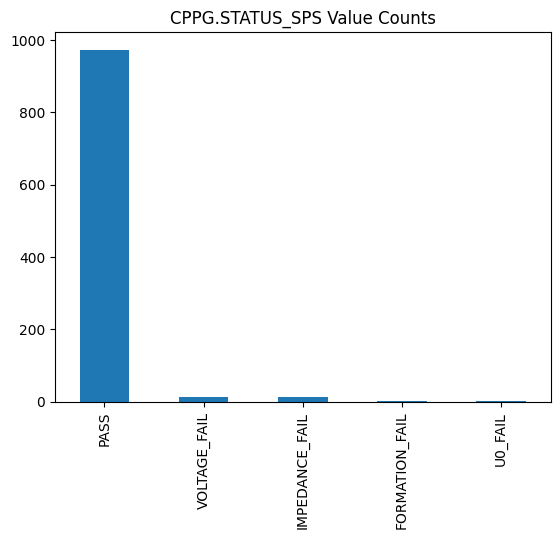

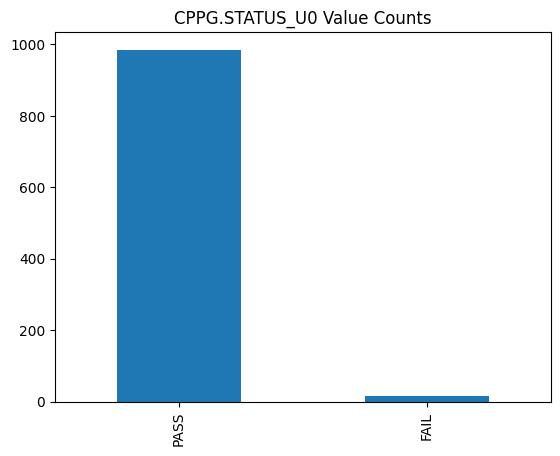

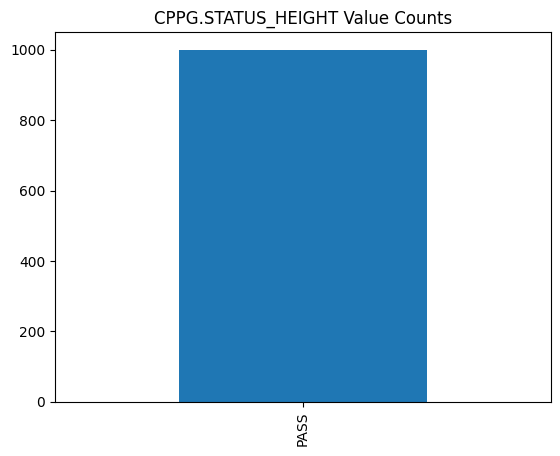

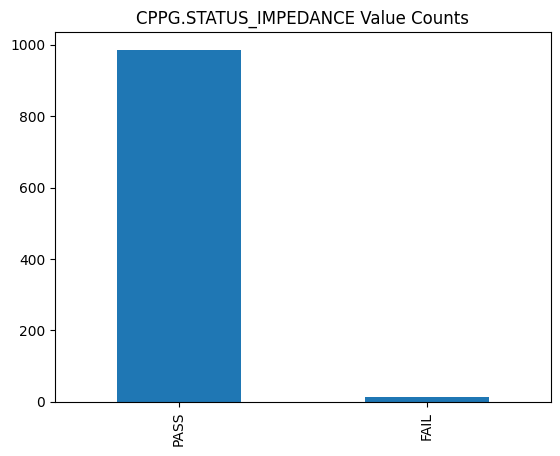

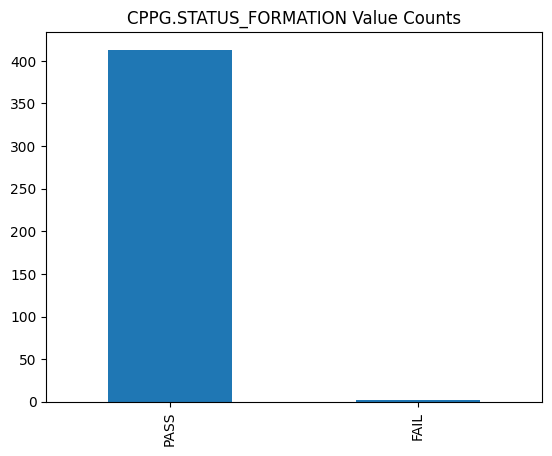

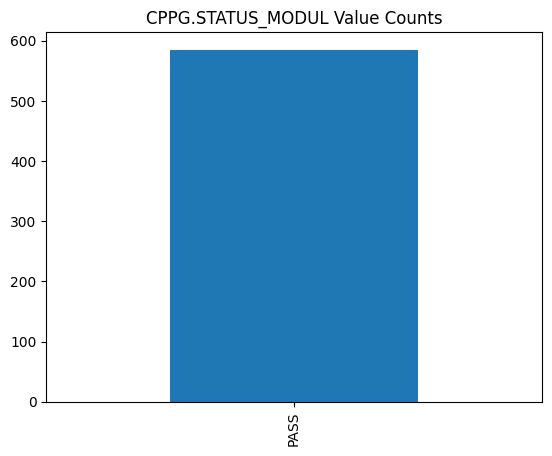

In [6]:
for column in cppg_df.columns:
    plt.figure()
    cppg_df[column].value_counts().plot.bar()
    plt.title(f'{column} Value Counts')
plt.show()

In [7]:
value_df = df.drop(columns=LABEL_COLS)
value_df.head()

,CPW.Name,CPW.Linie,CPW.Werk,CPW.Timestamp,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_FZLENGTH_LOWER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,...,CPX.CONV_ACOHs047_2,CPX.CONV_ACOHs048_2,CPM.RejectWelding,CPPG.REJECTED,CPW.Soll_DMC,CPX.CONV_ACOHs049,CPX.CONV_ACOHs050,CPM.WeldLogfile_Nr,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1
ID,,,,,,,,,,,,,,,,,,,,,
1,CPMW26,710.0,140.0,2022-08-29 02:00:32,61.268271,350.282969,9.179729,0.0,302.502813,12.28662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPMW23,707.0,140.0,2022-08-20 12:42:20,57.259561,348.452969,10.880899,0.0,301.902344,12.26344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPMW53,725.0,140.0,2022-08-31 16:23:37,58.295284,351.588750,10.690954,0.0,302.626719,12.29760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPMW27,711.0,140.0,2022-10-11 17:54:46,62.750492,351.843710,10.240900,0.0,303.179531,12.22806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CPMW23,707.0,140.0,2022-08-24 22:20:35,57.823748,350.698770,10.889323,0.0,310.547188,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Check here, whether other Fail Values are in DF
y = []

contains_failure = cppg_df.isin(["FAIL"]).any(axis=1)

for item in contains_failure:
    if item:
        y.append("FAIL")
    else:
        y.append("PASS")

In [19]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
value_distribution = pd.DataFrame([le.classes_[line] for line in y_encoded])
print(value_distribution.value_counts())

PASS    973
FAIL     27
dtype: int64


In [40]:
x_check = np.array(value_df)

### Upsample Fail Class 

In [43]:
ros = RandomOverSampler()
x_resampled, y_resampled = ros.fit_resample(np.array(value_df), y_encoded)
value_distribution = pd.DataFrame([le.classes_[line] for line in y_resampled])
print(value_distribution.value_counts())

FAIL    973
PASS    973
dtype: int64


In [44]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=RANDOM_STATE)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
print(f"Train Size: {len(y_train)} --- Validation Size: {len(y_val)} --- Test Size: {len(y_test)}")

Train Size: 1244 --- Validation Size: 312 --- Test Size: 390


In [45]:
dropout = 0.1
lr = 1e-03

In [46]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

model = Sequential()
model.add(Dense(64, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dropout(dropout))
model.add(Dense(512, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(64, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(len(le.classes_), activation="softmax"))

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=lr), metrics=["accuracy"])

In [51]:
print(value_df.dtypes)

CPW.Name                       object
CPW.Linie                     float64
CPW.Werk                      float64
CPW.Timestamp          datetime64[ns]
CPW.ANODE_FZLENGTH            float64
                            ...      
CPX.CONV_ACOHs049             float64
CPX.CONV_ACOHs050             float64
CPM.WeldLogfile_Nr            float64
CPX.CONV_ACOHs047_1           float64
CPX.CONV_ACOHs048_1           float64
Length: 473, dtype: object


In [48]:
history = model.fit(
    x_train, y_train,
    epochs=1,
    batch_size=10,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, reduce_lr],
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
predictions = model.predict(x_test)
acc = accuracy_score(y_test, predictions)
print(f"Accuracy of {round(acc*100,2)}%")
cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp = cm_display.plot(cmap="Blues")